# Feedback Prize Effectiveness: Model Training and Validation

This notebook covers the complete pipeline for training and validating a model to predict the effectiveness of discourse elements in student essays. The process includes:
1. **Setup and Configuration**: Importing necessary libraries and defining constants, including file paths and model hyperparameters.
2. **Data Loading and Preprocessing**: Loading the training data, including essay texts, and performing initial cleaning.
3. **Target Encoding**: Converting categorical effectiveness labels into numerical format.
4. **Metric Selection and Appropriateness**: Discussion of the Log Loss metric used for evaluation.
5. **Validation Strategy**: Justification of the stratified train-validation split.
6. **Tokenizer Initialization**: Setting up the tokenizer for the chosen pre-trained model.
7. **PyTorch Dataset and DataLoader Creation**: Defining a custom PyTorch Dataset and creating DataLoaders for efficient batch processing.
8. **Model Definition**: Loading a pre-trained transformer model for sequence classification.
9. **Optimizer, Scheduler, and Loss Function**: Configuring the optimizer, learning rate scheduler, and loss function.
10. **Training and Evaluation Loop**: Implementing the main loop for training the model and evaluating it on the validation set epoch by epoch.
11. **Saving the Best Model**: Storing the model weights that achieve the best validation performance.

In [1]:
# --- Cell 1: Setup and Configuration ---
import os
import warnings

# Suppress the Tqdm IProgress not found warning
warnings.filterwarnings("ignore", message="IProgress not found. Please update jupyter and ipywidgets.")

import pandas as pd
import os
from tqdm import tqdm
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import math
import datetime

# --- Weights & Biases Setup ---
import wandb
# Ensure you have logged in to wandb separately (e.g., `wandb login` in terminal or set API key)

# --- Set TOKENIZERS_PARALLELISM to false to suppress the warning ---
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# --- Project Directory Structure ---
PROJECT_ROOT = "../"
DATA_DIR = os.path.join(PROJECT_ROOT, "data/feedback-prize-effectiveness/")
MODELS_OUTPUT_DIR = os.path.join(PROJECT_ROOT, "models/")

TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
# TEST_CSV is defined but primarily for structure/submission, not for hidden test simulation
TEST_CSV = os.path.join(DATA_DIR, "test.csv")
TRAIN_ESSAYS_DIR = os.path.join(DATA_DIR, "train/")
TEST_ESSAYS_DIR = os.path.join(DATA_DIR, "test/")

if not os.path.exists(MODELS_OUTPUT_DIR):
    os.makedirs(MODELS_OUTPUT_DIR)
    print(f"Created models directory: {MODELS_OUTPUT_DIR}")

# --- Model and Training Hyperparameters ---
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 512
NUM_LABELS = 3 # Initial guess, will be confirmed by LabelEncoder

LEARNING_RATE = 2e-5
ADAM_EPSILON = 1e-8
BATCH_SIZE = 8
EPOCHS = 2
WARMUP_STEPS_RATIO = 0.1

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- wandb Initialization ---
wandb.init(
    project="feedback-prize-effectiveness-lab",  # Choose your project name
    entity=None, # wandb username or team (can be set via env WANDB_ENTITY)
    config={
        "model_name": MODEL_NAME,
        "max_len": MAX_LEN,
        "learning_rate": LEARNING_RATE,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "warmup_steps_ratio": WARMUP_STEPS_RATIO,
        "adam_epsilon": ADAM_EPSILON,
        "device": str(device),
        "validation_split_ratio": 0.1, 
        "random_state_split": 42 
    },
    name=f"{MODEL_NAME}-e{EPOCHS}-lr{LEARNING_RATE}-bs{BATCH_SIZE}-{time.strftime('%Y%m%d-%H%M')}",
    notes="Training run for IASA NLP Lab1.",
    dir=os.path.join(PROJECT_ROOT, "outputs")
)
# NUM_LABELS will be updated in wandb.config after LabelEncoder fitting

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Using device: cuda


wandb: Currently logged in as: denis-katkalo (denis-katkalo-kpi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 1. Data Loading and Preprocessing
This section involves loading the `train.csv` data and the full text of each essay.

In [2]:
# Cell 2: Helper Function - Load Essay Texts
def load_essay_texts(essay_ids, essays_dir):
    """Loads the full text for a list of essay IDs from the specified directory."""
    essay_texts = {}
    for essay_id in tqdm(essay_ids, desc=f"Loading essays from {essays_dir}"):
        essay_path = os.path.join(essays_dir, f"{essay_id}.txt")
        try:
            with open(essay_path, 'r') as f:
                essay_texts[essay_id] = f.read()
        except FileNotFoundError:
            print(f"Warning: Essay file not found {essay_path}")
            essay_texts[essay_id] = "" # Provide an empty string if not found
    return essay_texts

In [3]:
# Cell 3: Main Data Loading
print(f"Loading {TRAIN_CSV}...")
df_train = pd.read_csv(TRAIN_CSV)
# df_test = pd.read_csv(TEST_CSV) # Test data for submission is loaded

print(f"Train data original shape: {df_train.shape}")

train_essay_ids = df_train['essay_id'].unique()
train_essay_texts_map = load_essay_texts(train_essay_ids, TRAIN_ESSAYS_DIR)

df_train['essay_full_text'] = df_train['essay_id'].map(train_essay_texts_map)

# Fill any potential NaN values in text columns with empty strings (or a placeholder)
df_train['discourse_text'] = df_train['discourse_text'].fillna('')
df_train['essay_full_text'] = df_train['essay_full_text'].fillna('')

print(f"\nNumber of rows in train_df with missing 'discourse_text' after fillna: {df_train['discourse_text'].eq('').sum()}")
print(f"Number of rows in train_df with missing 'essay_full_text' after fillna: {df_train['essay_full_text'].eq('').sum()}")
print(f"\nTrain data shape after loading essays: {df_train.shape}")
print("\nFirst 5 rows of training data:")
print(df_train.head())

Loading ../data/feedback-prize-effectiveness/train.csv...
Train data original shape: (36765, 5)


Loading essays from ../data/feedback-prize-effectiveness/train/: 100%|██████████| 4191/4191 [00:00<00:00, 4641.79it/s]


Number of rows in train_df with missing 'discourse_text' after fillna: 0
Number of rows in train_df with missing 'essay_full_text' after fillna: 0

Train data shape after loading essays: (36765, 6)

First 5 rows of training data:
   discourse_id      essay_id  \
0  0013cc385424  007ACE74B050   
1  9704a709b505  007ACE74B050   
2  c22adee811b6  007ACE74B050   
3  a10d361e54e4  007ACE74B050   
4  db3e453ec4e2  007ACE74B050   

                                      discourse_text discourse_type  \
0  Hi, i'm Isaac, i'm going to be writing about h...           Lead   
1  On my perspective, I think that the face is a ...       Position   
2  I think that the face is a natural landform be...          Claim   
3  If life was on Mars, we would know by now. The...       Evidence   
4  People thought that the face was formed by ali...   Counterclaim   

  discourse_effectiveness                                    essay_full_text  
0                Adequate  Hi, i'm Isaac, i'm going to be writin

## 2. Target Encoding
The target labels ('Ineffective', 'Adequate', 'Effective') are converted into numerical format using `LabelEncoder`.

In [4]:
# --- Cell 4: Target Encoding ---
label_encoder = LabelEncoder()
df_train['effectiveness_encoded'] = label_encoder.fit_transform(df_train['discourse_effectiveness'])

# Update NUM_LABELS based on the fitted encoder AND update wandb config
NUM_LABELS = len(label_encoder.classes_)
wandb.config.update({"num_labels": NUM_LABELS}, allow_val_change=True) # Log actual NUM_LABELS

print("Label Encoding Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: {i}")
print(f"Number of unique labels: {NUM_LABELS}")

print("\nTrain DataFrame with encoded labels (first 5 rows):")
print(df_train[['discourse_effectiveness', 'effectiveness_encoded']].head())

Label Encoding Mapping:
Adequate: 0
Effective: 1
Ineffective: 2
Number of unique labels: 3

Train DataFrame with encoded labels (first 5 rows):
  discourse_effectiveness  effectiveness_encoded
0                Adequate                      0
1                Adequate                      0
2                Adequate                      0
3                Adequate                      0
4                Adequate                      0


## 3. Development of Validation Strategy: Simulating the Hidden Test Set

The `test.csv` provided for this Kaggle competition is a small sample file, not the actual hidden test set used for final scoring. Therefore, our primary method is to create a reliable hold-out validation set from our available `train.csv` data.

### 3.1. Chosen Strategy: Stratified Train-Validation Split

We use a **stratified 90/10 train-validation split** from `train.csv`.

**Justification for Simulating the Split:**

* **Mimicking Unseen Data:** This local validation set contains data the model hasn't been trained on for a given iteration, which is how we simulate performance on an unseen hidden test set.
* **Stratification for Representativeness:** Given the class imbalance observed during EDA, stratification ensures our validation set reflects the training data's class distribution. This is crucial for a more reliable estimate of performance, assuming the hidden test set shares similar class proportions.
* **Baseline Generalization Check:** Performance on this local split serves as our primary proxy for how the model might generalize to the actual Kaggle test data.

**Limitations and Robustness Considerations:**

A single train-validation split provides a useful baseline but can be subject to some variability depending on the specific samples that end up in the split. For a more robust simulation of performance on unseen data, K-Fold Cross-Validation (particularly `StratifiedKFold` or `GroupKFold` by `essay_id` to ensure essay integrity within folds) would be a preferred approach if time and computational resources permitted. This involves training and evaluating the model multiple times on different subsets of the data, giving a more stable performance estimate. For this lab, our single stratified split serves as a practical and informative baseline.

In [5]:
# Cell 5: Data Splitting
df_train_split, df_val_split = train_test_split(
    df_train,
    test_size=0.1, # 10% for validation
    random_state=42, # For reproducibility
    stratify=df_train['effectiveness_encoded'] # Ensure proportional class representation
)

print(f"Data split sizes:")
print(f"  Training set: {len(df_train_split)} samples")
print(f"  Validation set: {len(df_val_split)} samples")

Data split sizes:
  Training set: 33088 samples
  Validation set: 3677 samples


## 4. Tokenizer and PyTorch Dataset

### 4.1. Tokenizer Initialization
We use the `AutoTokenizer` from the Hugging Face `transformers` library, corresponding to the chosen `MODEL_NAME`.

In [6]:
# Cell 6: Tokenizer Initialization
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

### 4.2. PyTorch Dataset Class
A custom `Dataset` class is defined to handle the tokenization and formatting of input data (discourse text and essay full text) for the model. It prepares `input_ids`, `attention_mask`, `token_type_ids`, and `labels`.

In [7]:
# Cell 7: PyTorch Dataset Class
class FeedbackPrizeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, has_labels=True):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.has_labels = has_labels

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        text_A = str(row.discourse_text) if pd.notna(row.discourse_text) and str(row.discourse_text).strip() else " "
        text_B = str(row.essay_full_text) if pd.notna(row.essay_full_text) and str(row.essay_full_text).strip() else " "

        # Ensure texts are not just whitespace, which can cause issues with some tokenizers
        if not text_A.strip(): text_A = "[EMPTY_DISCOURSE]" # Use a placeholder or just a space
        if not text_B.strip(): text_B = "[EMPTY_ESSAY]"   # Use a placeholder or just a space

        inputs = self.tokenizer.encode_plus(
            text_A,
            text_B,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation='longest_first', # Truncate the longer sequence if combined length exceeds max_len
            return_attention_mask=True,
            return_token_type_ids=True, # For models that use segment embeddings (like BERT)
            return_tensors='pt'
        )

        item = {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs['token_type_ids'].flatten()
        }

        if self.has_labels:
            item['labels'] = torch.tensor(row.effectiveness_encoded, dtype=torch.long)

        return item

### 4.3. Example Dataset Instantiation and Item Check
This cell demonstrates the usage of the `FeedbackPrizeDataset` and allows inspection of a sample item.

In [8]:
# Cell 8: Dataset Instantiation and Check
print("Instantiating example training dataset...")

example_check_df = df_train_split.head() # Or df_train.head() if before split
temp_dataset = FeedbackPrizeDataset(example_check_df, tokenizer, MAX_LEN, has_labels=True)

if len(temp_dataset) > 0:
    print(f"Successfully created example dataset with {len(temp_dataset)} samples.")
    sample_item = temp_dataset[0]
    print("\nSample item from dataset (index 0):")
    for key, value in sample_item.items():
        print(f"  {key}: shape {value.shape}, dtype {value.dtype}")
    decoded_text = tokenizer.decode(sample_item['input_ids'], skip_special_tokens=False)
    print(f"\n  Decoded input_ids (index 0):\n  '{decoded_text}'")
else:
    print("Example dataset is empty or not run.")

Instantiating example training dataset...
Successfully created example dataset with 5 samples.

Sample item from dataset (index 0):
  input_ids: shape torch.Size([512]), dtype torch.int64
  attention_mask: shape torch.Size([512]), dtype torch.int64
  token_type_ids: shape torch.Size([512]), dtype torch.int64
  labels: shape torch.Size([]), dtype torch.int64

  Decoded input_ids (index 0):
  '[CLS] during free time, students aren ' t putting their time into anything anyway. letting them use their phones will have no affect what so ever or anything important, such as school work. [SEP] dear principal, out of the two possible policies you are considering i would have to say that i favor the second. the idea of allowing students to use cell phones during free time makes absolute sense. not allowing the phones during class time is respectable as well, that way the learning isn ' t affected. during free time, students aren ' t putting their time into anything anyway. letting them use their p

## 5. Model Definition
We load the pre-trained transformer model (`AutoModelForSequenceClassification`) with a classification head appropriate for `NUM_LABELS`. The model is then moved to the configured `device` (GPU or CPU).

In [9]:
# Cell 9: Model Definition
print(f"Defining model: {MODEL_NAME} for {NUM_LABELS} classes.")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)
model.to(device)
print(f"Model loaded on device: {device}")

# To see the model architecture (can be very verbose):
print("\nModel Architecture:")
print(model)

Defining model: bert-base-uncased for 3 classes.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on device: cuda

Model Architecture:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
 

## 6. DataLoader Creation
PyTorch `DataLoader`s are created for the training and validation sets. These handle batching, shuffling (for training), and parallel data loading.

In [10]:
# Cell 10: DataLoader Creation
train_torch_dataset = FeedbackPrizeDataset(df_train_split, tokenizer, MAX_LEN, has_labels=True)
val_torch_dataset = FeedbackPrizeDataset(df_val_split, tokenizer, MAX_LEN, has_labels=True)
# test_torch_dataset is created in the prediction notebook

# Determine num_workers for DataLoader
# Using a simple approach here; os.sched_getaffinity might not be available on all platforms.
try:
    num_avail_workers = len(os.sched_getaffinity(0)) // 2
except AttributeError:
    num_avail_workers = (os.cpu_count() // 2) if os.cpu_count() and os.cpu_count() > 1 else 0
num_avail_workers = max(0, num_avail_workers) # Ensure non-negative
# For debugging or on platforms with issues, set num_avail_workers = 0
# num_avail_workers = 0
print(f"Attempting to use {num_avail_workers} workers for DataLoaders.")


train_dataloader = DataLoader(
    train_torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_avail_workers,
    pin_memory=True if device.type == 'cuda' else False
)

val_dataloader = DataLoader(
    val_torch_dataset,
    batch_size=BATCH_SIZE * 2, # Typically use larger batch size for validation
    shuffle=False,
    num_workers=num_avail_workers,
    pin_memory=True if device.type == 'cuda' else False
)

print("\nDataLoaders created.")
print(f"  Train DataLoader: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"  Validation DataLoader: {len(val_dataloader)} batches of size {BATCH_SIZE * 2}")

Attempting to use 12 workers for DataLoaders.

DataLoaders created.
  Train DataLoader: 4136 batches of size 8
  Validation DataLoader: 230 batches of size 16


## 7. Optimizer, Scheduler, and Loss Function
* **Optimizer**: `AdamW` is chosen, a common optimizer for transformer models.
* **Scheduler**: A linear learning rate scheduler with warmup (`get_linear_schedule_with_warmup`) is used.
* **Loss Function**: `nn.CrossEntropyLoss` is used, suitable for multi-class classification.

In [11]:
# Cell 11: Optimizer, Scheduler, Loss
optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  eps=ADAM_EPSILON)

total_steps = len(train_dataloader) * EPOCHS
num_warmup_steps = math.ceil(total_steps * WARMUP_STEPS_RATIO)

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=num_warmup_steps,
                                            num_training_steps=total_steps)

criterion = nn.CrossEntropyLoss() 

print("Optimizer, Scheduler, and Loss Function (criterion) initialized.")
print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {num_warmup_steps}")

Optimizer, Scheduler, and Loss Function (criterion) initialized.
Total training steps: 8272
Warmup steps: 828


/home/denis/kpi/iasa_nlp_labs/feedback_prize_effectiveness/.venv/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 8. Training and Evaluation Loop
The main loop iterates for a specified number of `EPOCHS`. In each epoch:
1.  The model is set to `train` mode, and training is performed on batches from `train_dataloader`.
2.  The model is set to `eval` mode, and evaluation is performed on `val_dataloader`.
3.  Metrics (loss, accuracy, log loss) are calculated and recorded.
4.  The model and tokenizer that achieve the best validation log loss are saved.

In [12]:
# --- Code Cell (Cell 12: Training and Evaluation Loop) ---
def format_time(elapsed_seconds):
    """Takes a time in seconds and returns a string H:MM:SS"""
    elapsed_rounded = int(round(elapsed_seconds))
    return str(datetime.timedelta(seconds=elapsed_rounded))

training_stats = []
best_val_logloss = float('inf')

# Optional: Watch model gradients and parameters (can be resource-intensive)
# wandb.watch(model, log="all", log_freq=100)

print(f"Starting training for {EPOCHS} epochs...") # EPOCHS from config

for epoch_i in range(wandb.config.epochs): # Use wandb.config.epochs
    print(f"\n======== Epoch {epoch_i + 1} / {wandb.config.epochs} ========")
    epoch_start_time = time.time()

    # --- Training Phase ---
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Training Batches"):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_token_type_ids = batch['token_type_ids'].to(device)
        b_labels = batch['labels'].to(device)

        model.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids=b_token_type_ids,
                        attention_mask=b_attention_mask,
                        labels=b_labels)

        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    epoch_training_time = format_time(time.time() - t0)
    print(f"  Average training loss: {avg_train_loss:.4f}")
    print(f"  Training epoch took: {epoch_training_time}")

    # --- Validation Phase ---
    print("\nRunning Validation...")
    t0 = time.time()
    model.eval()
    total_eval_loss = 0
    all_val_preds_probs = []
    all_val_labels = []

    for batch in tqdm(val_dataloader, total=len(val_dataloader), desc="Validation Batches"):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_token_type_ids = batch['token_type_ids'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=b_token_type_ids,
                            attention_mask=b_attention_mask,
                            labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        all_val_preds_probs.extend(probs)
        all_val_labels.extend(b_labels.to('cpu').numpy())

    avg_val_CE_loss = total_eval_loss / len(val_dataloader)
    all_val_preds_probs_stacked = np.vstack(all_val_preds_probs)
    all_val_labels_flat = np.array(all_val_labels)
    all_val_preds_classes = np.argmax(all_val_preds_probs_stacked, axis=1)
    val_accuracy = accuracy_score(all_val_labels_flat, all_val_preds_classes)
    val_logloss_metric = log_loss(all_val_labels_flat, all_val_preds_probs_stacked, labels=label_encoder.transform(label_encoder.classes_))
    epoch_validation_time = format_time(time.time() - t0)

    print(f"  Validation CrossEntropy Loss: {avg_val_CE_loss:.4f}")
    print(f"  Validation LogLoss (Competition Metric): {val_logloss_metric:.4f}")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")
    print(f"  Validation took: {epoch_validation_time}")

    # --- Log metrics to wandb ---
    wandb.log({
        "epoch": epoch_i + 1, # Log epoch
        "avg_train_loss": avg_train_loss,
        "avg_val_CE_loss": avg_val_CE_loss,
        "val_logloss": val_logloss_metric,
        "val_accuracy": val_accuracy,
        "learning_rate": scheduler.get_last_lr()[0] # Log current learning rate
    })

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. CE Loss': avg_val_CE_loss,
        'Valid. LogLoss': val_logloss_metric,
        'Valid. Accur.': val_accuracy,
        'Training Time': epoch_training_time,
        'Validation Time': epoch_validation_time
    })

    if val_logloss_metric < best_val_logloss:
        best_val_logloss = val_logloss_metric
        best_model_dir = os.path.join(MODELS_OUTPUT_DIR, "best_model")
        if not os.path.exists(best_model_dir):
            os.makedirs(best_model_dir)
        model_save_path = os.path.join(best_model_dir, f"{wandb.config.model_name}-best.pt") # Use wandb.config
        tokenizer_save_path = best_model_dir
        torch.save(model.state_dict(), model_save_path)
        tokenizer.save_pretrained(tokenizer_save_path)
        print(f"  Best validation logloss improved to {best_val_logloss:.4f}. Saving model to {model_save_path}")

        # Update wandb summary with best scores
        wandb.summary["best_val_logloss"] = best_val_logloss
        wandb.summary["best_val_accuracy"] = val_accuracy
        wandb.summary["best_epoch"] = epoch_i + 1
        
        # Optional: Save best model as a wandb artifact
        best_model_artifact = wandb.Artifact(f"{wandb.run.name}-best-model", type="model")
        best_model_artifact.add_file(model_save_path)
        tokenizer_files = [os.path.join(tokenizer_save_path, f) for f in os.listdir(tokenizer_save_path) if os.path.isfile(os.path.join(tokenizer_save_path, f))]
        for f_path in tokenizer_files:
           best_model_artifact.add_file(f_path, name=os.path.basename(f_path))
        wandb.log_artifact(best_model_artifact)


print("\n======== Training complete! ========\n")
print(f"Best validation LogLoss achieved: {best_val_logloss:.4f}")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
print("\nTraining statistics:")
print(df_stats)

# Optional: Log final stats table as wandb.Table
if not df_stats.empty:
    wandb.log({"training_summary_table": wandb.Table(dataframe=df_stats.reset_index())})

# --- Finish wandb run ---
wandb.finish()

Starting training for 2 epochs...

======== Epoch 1 / 2 ========
Training...


Training Batches: 100%|██████████| 4136/4136 [13:35<00:00,  5.07it/s]


  Average training loss: 0.7328
  Training epoch took: 0:13:35

Running Validation...


Validation Batches: 100%|██████████| 230/230 [00:26<00:00,  8.67it/s]


  Validation CrossEntropy Loss: 0.6131
  Validation LogLoss (Competition Metric): 0.6131
  Validation Accuracy: 0.7308
  Validation took: 0:00:27
  Best validation logloss improved to 0.6131. Saving model to ../models/best_model/bert-base-uncased-best.pt

======== Epoch 2 / 2 ========
Training...


Training Batches: 100%|██████████| 4136/4136 [13:24<00:00,  5.14it/s]


  Average training loss: 0.5792
  Training epoch took: 0:13:25

Running Validation...


Validation Batches: 100%|██████████| 230/230 [00:23<00:00,  9.94it/s]


  Validation CrossEntropy Loss: 0.5921
  Validation LogLoss (Competition Metric): 0.5918
  Validation Accuracy: 0.7473
  Validation took: 0:00:23
  Best validation logloss improved to 0.5918. Saving model to ../models/best_model/bert-base-uncased-best.pt

======== Training complete! ========

Best validation LogLoss achieved: 0.5918

Training statistics:
       Training Loss  Valid. CE Loss  Valid. LogLoss  Valid. Accur.  \
epoch                                                                 
1           0.732809        0.613145        0.613086       0.730759   
2           0.579217        0.592054        0.591801       0.747348   

      Training Time Validation Time  
epoch                                
1           0:13:35         0:00:27  
2           0:13:25         0:00:23  


avg_train_loss,█▁
avg_val_CE_loss,█▁
epoch,▁█
learning_rate,█▁
val_accuracy,▁█
val_logloss,█▁
avg_train_loss,0.57922
avg_val_CE_loss,0.59205
best_epoch,2
best_val_accuracy,0.74735
best_val_logloss,0.5918


## 9. Next Steps
- **Plot Training Curves**: Visualize training loss, validation loss, and validation accuracy over epochs.
- **Error Analysis**: Investigate samples where the model performed poorly.
- **Prediction on Test Set**: Use the saved best model to generate predictions for the actual test set (done in `prediction_and_submission.ipynb`).
- **Experiment Tracking**: Integrate tools like Weights & Biases or MLflow for more comprehensive experiment logging and comparison (as per lab instructions).

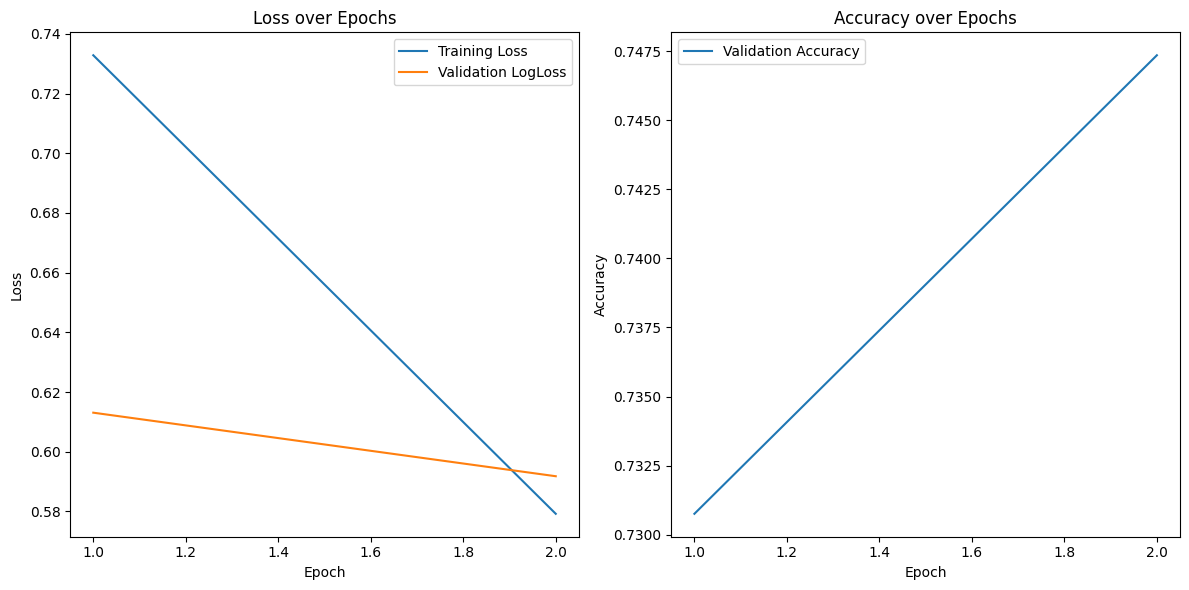

Training curves plot saved to ../outputs/training_curves.png


<Figure size 640x480 with 0 Axes>

In [13]:
# To plot training curves (example using matplotlib):
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_stats.index, df_stats['Training Loss'], label='Training Loss')
plt.plot(df_stats.index, df_stats['Valid. LogLoss'], label='Validation LogLoss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_stats.index, df_stats['Valid. Accur.'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save the plot
plot_path = os.path.join(PROJECT_ROOT, "outputs", "training_curves.png")
plt.savefig(plot_path)
print(f"Training curves plot saved to {plot_path}")

<img src="../outputs/result.png"/>

## 6. Conclusions

This project tackled the classification of discourse effectiveness in student essays using a `bert-base-uncased` model. Key takeaways are:

* **Approach:** I fine-tuned `bert-base-uncased` on a combination of discourse and full essay texts. A stratified 90/10 train-validation split was used for local evaluation due to the Kaggle `test.csv` being a small, non-representative sample. Weights & Biases (`wandb`) helped track experiments.
* **Performance:**
    * **Local Best:** Achieved a Log Loss of **0.5725** and ~74.93% accuracy on our validation set.
    * **Kaggle Scores:** Public LogLoss **0.75670**, Private LogLoss **0.73063**.
    * The gap between local and Kaggle scores highlights the challenge of perfectly simulating the hidden test set with a local split.
* **Key Learning:** Transformer models are effective for this task. However, robust local validation that closely mimics the hidden test set is crucial and challenging.
* **Limitations:** Time constraints limited training to 2 epochs and prevented more extensive experimentation (e.g., deeper hyperparameter tuning or K-Fold cross-validation).
* **Next Step Recommendation:** For improved reliability, employing `GroupKFold` cross-validation (grouped by `essay_id`) would be a valuable next step to better estimate model generalization.

Overall, the project established a working pipeline and achieved reasonable results, underscoring the importance of both model choice and validation strategy in NLP tasks.